In [1]:

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import matplotlib

In [2]:

((trainX, trainY), (testX, testY)) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):

  # 레이블 1인 영상의 인덱스
	validIdxs = np.where(labels == validLabel)[0]
  # 레이블 3인 영상의 인덱스
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

  # 무작위로 섞어 주고
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

  # 비정상 데이터의 갯수를 비정상 데이터 갯수 대비 0.01(contam)로 한다.
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	print("len(validIdx)=",len(validIdxs))
	print("len(anomalyIdxs)=",len(anomalyIdxs))

  # 추려낸 정상 데이터와 비정상 제이터
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

  # 두개의 데이터를 합하고, 다시 섞어주고
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	return images

images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

len(validIdx)= 6742
len(anomalyIdxs)= 67


In [4]:
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28)
255
0


In [5]:
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28, 1)
1.0
0.0


In [6]:
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)
print(trainX.shape)
print(testX.shape)

(5447, 28, 28, 1)
(1362, 28, 28, 1)


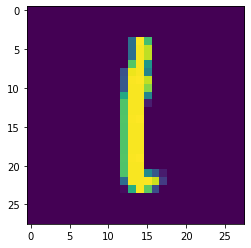

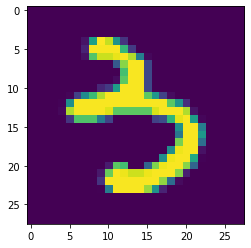

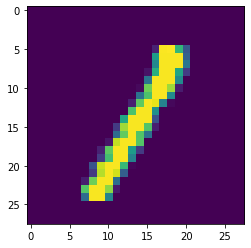

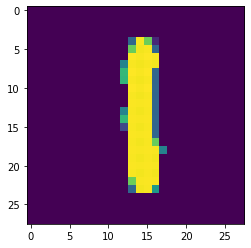

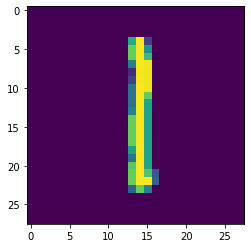

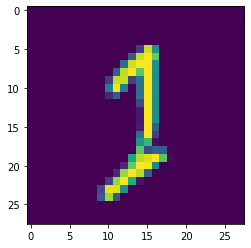

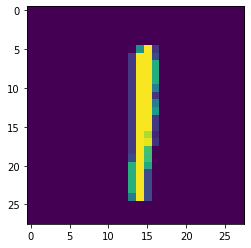

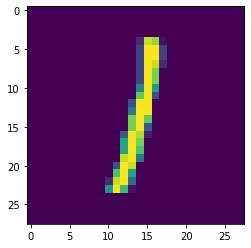

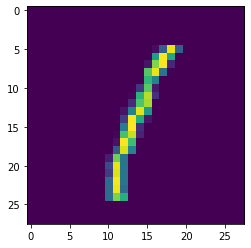

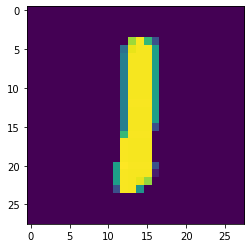

In [7]:
for i in range(10):
  plt.imshow(trainX[i].reshape((28,28)))
  plt.show()

In [8]:
class ConvAutoencoder:

	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1

		inputs = Input(shape=inputShape)
		x = inputs

		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		encoder = Model(inputs, latent, name="encoder")




		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		decoder = Model(latentInputs, outputs, name="decoder")



		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")


		return autoencoder

In [9]:
autoencoder = ConvAutoencoder.build(28, 28, 1)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [10]:
# decay값은 1 step 마다 감소하는 비율
opt = Adam(learning_rate=1e-3, decay=0.0025)
autoencoder.compile(loss="mse", optimizer=opt)

In [11]:
history = autoencoder.fit(trainX, trainX, validation_split=0.1, epochs=20, batch_size=32)

Epoch 1/20
154/154 [==============================] - 13s 7ms/step - loss: 0.0467 - val_loss: 0.0418
Epoch 2/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0305
Epoch 3/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0060 - val_loss: 0.0129
Epoch 4/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 5/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 6/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 8/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/20
154/154 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.002

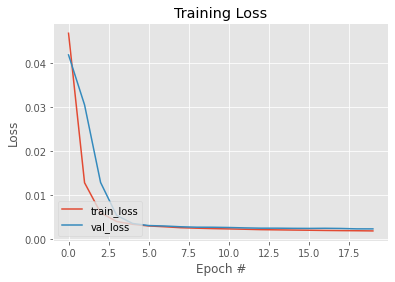

In [12]:
N = np.arange(len(history.history['loss']))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

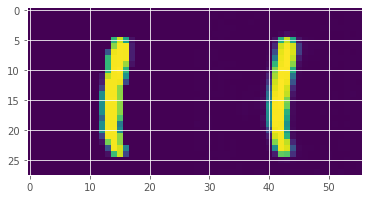

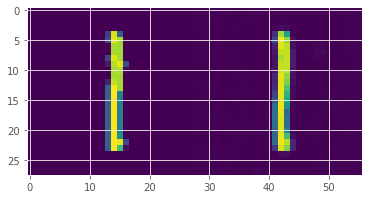

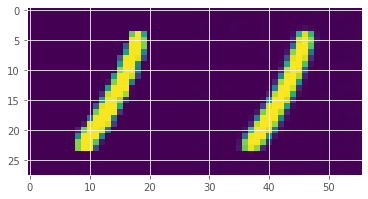

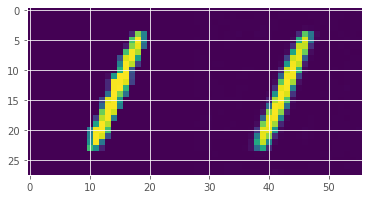

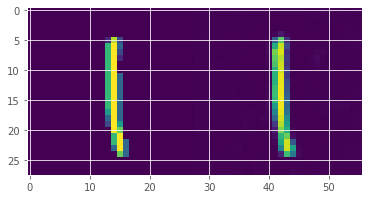

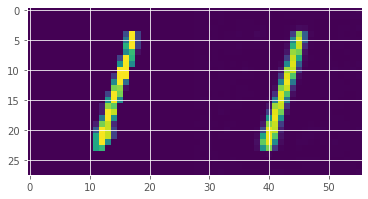

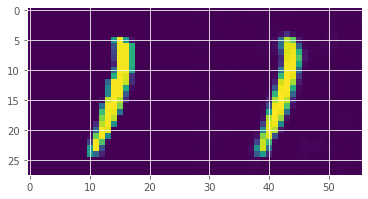

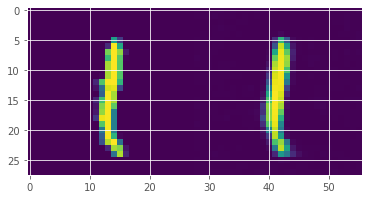

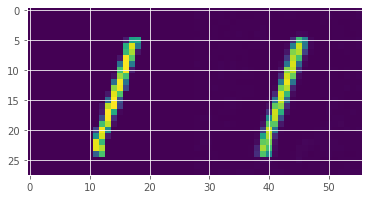

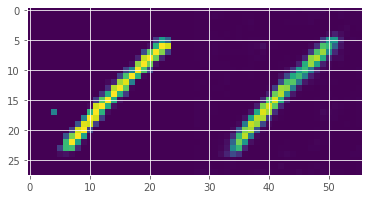

In [13]:
reconstructed = autoencoder.predict(testX)
for i in range(10):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

In [14]:
reconstructed = autoencoder.predict(testX)

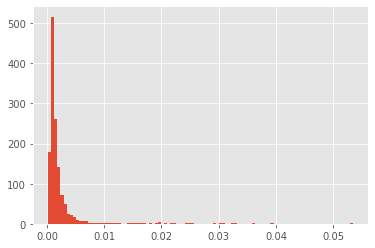

In [15]:
errors = []

for (image, recon) in zip(testX, reconstructed):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
plt.hist(errors, bins=100)
plt.show()

In [16]:
threshold = np.quantile(errors, 0.99)
print(threshold)

0.021159704104066018


In [17]:
anomaly_idxs = np.where(np.array(errors) >= threshold)[0]
print(len(anomaly_idxs))

14


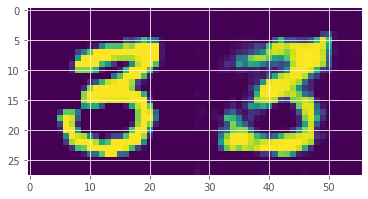

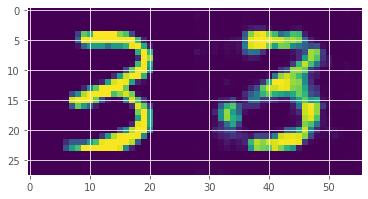

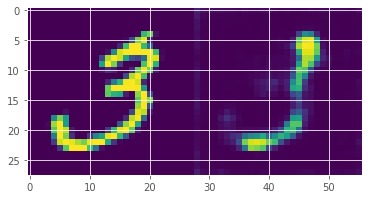

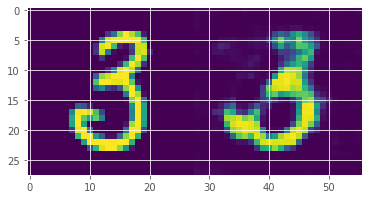

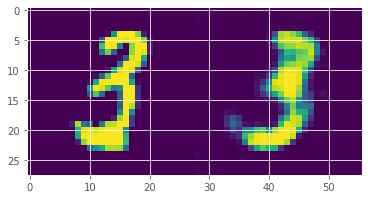

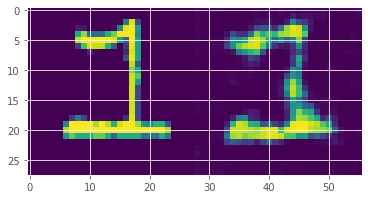

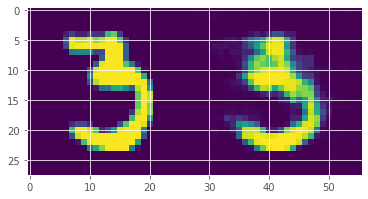

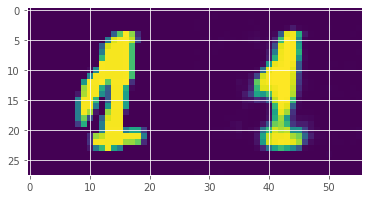

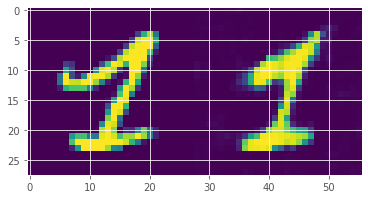

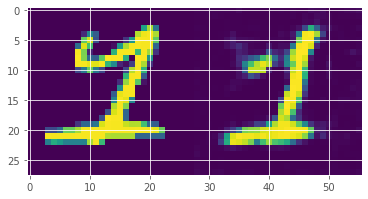

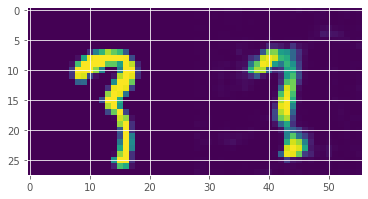

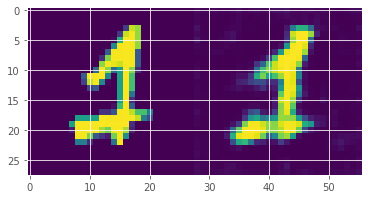

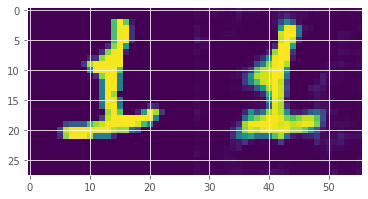

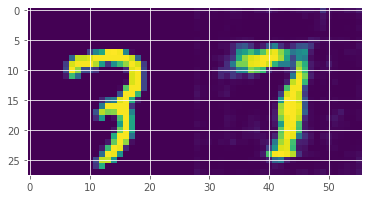

In [18]:
for i in anomaly_idxs:
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

In [19]:


((trainX, trainY), (testX, testY)) = mnist.load_data()
testX = np.expand_dims(testX, axis=-1)
testX = testX.astype("float32") / 255.0
print(testX.shape)
print(reconstructed.shape)

(10000, 28, 28, 1)
(1362, 28, 28, 1)


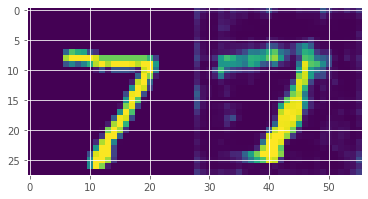

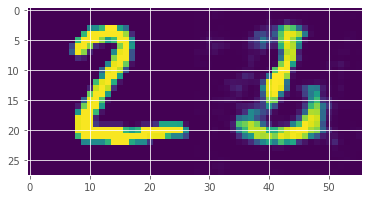

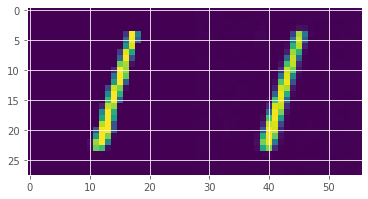

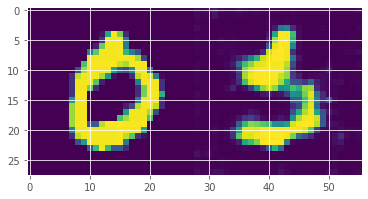

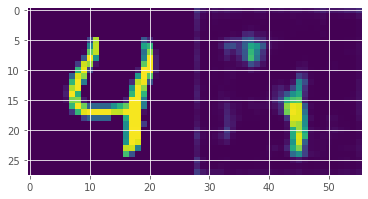

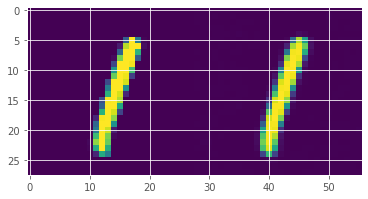

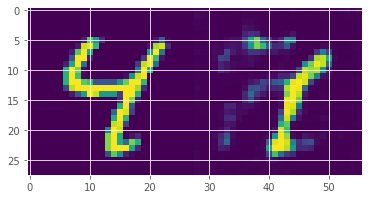

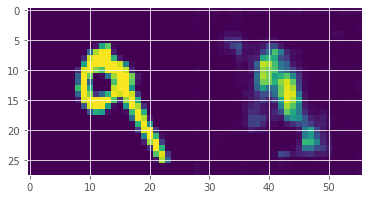

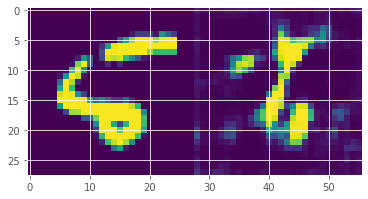

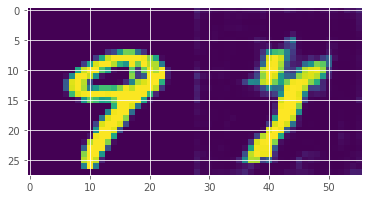

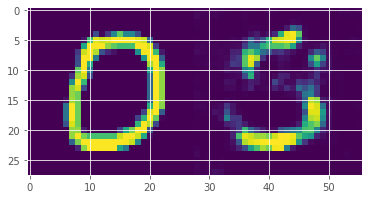

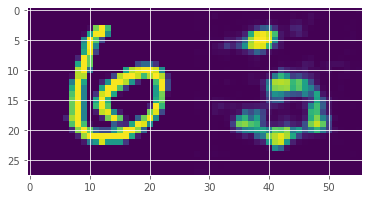

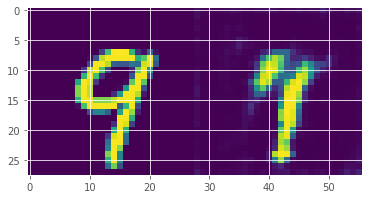

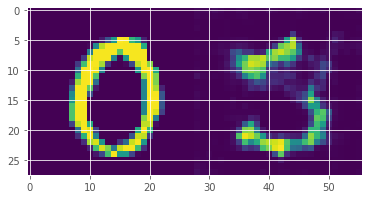

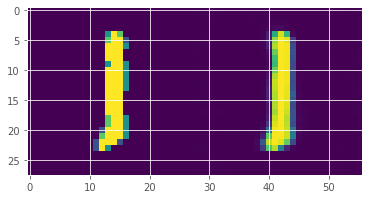

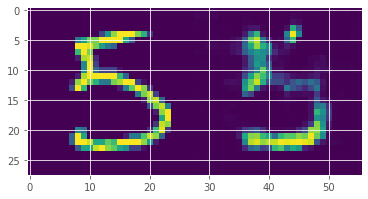

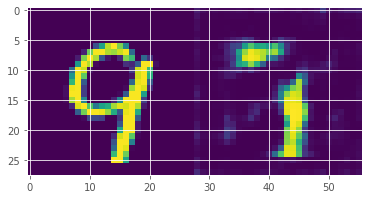

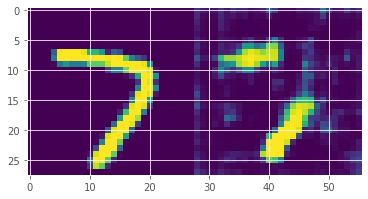

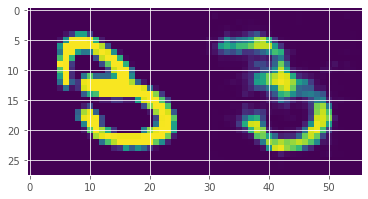

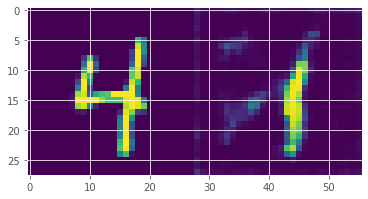

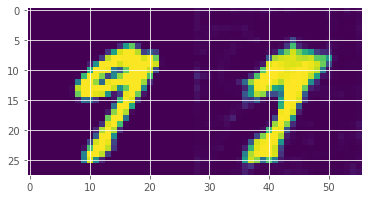

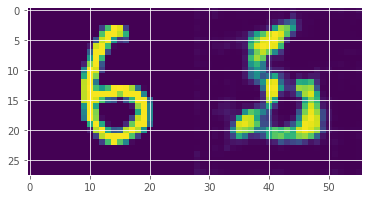

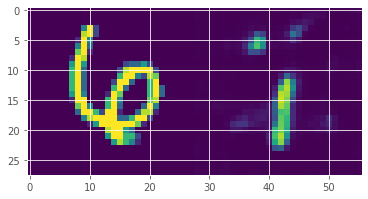

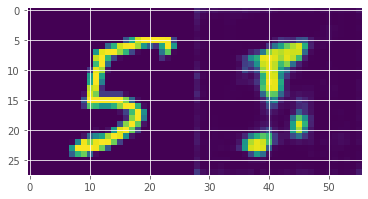

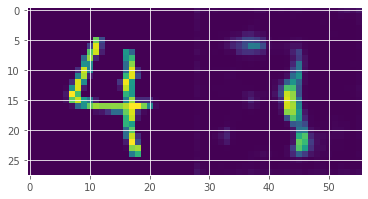

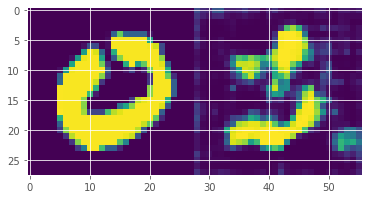

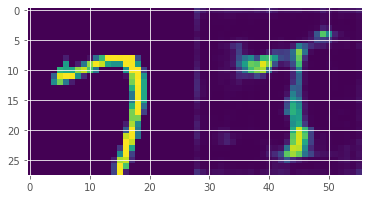

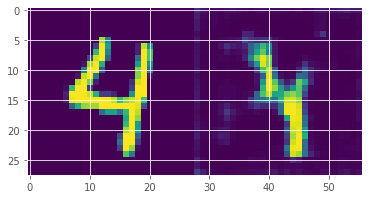

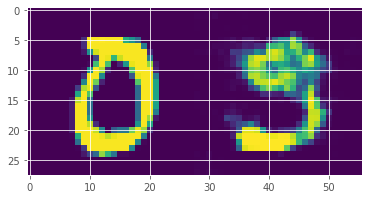

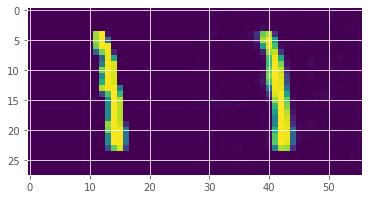

In [20]:
reconstructed = autoencoder.predict(testX)

for i in range(30):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()